# Display test results for a sample blend

This notebook demonstrates the results of deblending a sample blend using various initialization methods.

In [1]:
# Import Packages and setup
import logging
import os

import numpy as np
import scarlet
import scarlet.display
from scarlet import modeling

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='magma')
matplotlib.rc('image', interpolation='none')

loading data from'/Users/fred/lsst/data/psf_test/deep/blend_35.npz'


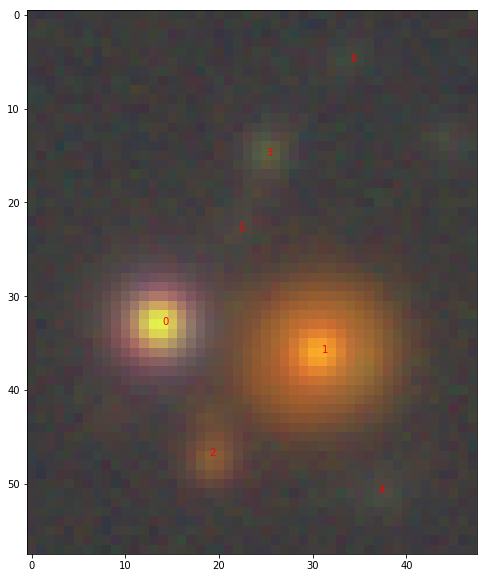

In [2]:
indices = [1, 11, 14, 15, 22, 35, 47, 54, 60, 89, 91, 100, 106, 112]

datapath = "/Users/fred/lsst/data/psf_test/deep"
filter_indices = [2, 1, 0]
stretch = .5
Q = 10

idx = 35

filename = "blend_{0}.npz".format(idx)
print("loading data from'{0}'".format(os.path.join(datapath, filename)))
data = np.load(os.path.join(datapath, filename))

images = data["image"].astype(float)
mask = data["mask"]
variance = data["variance"]
weights = 1/variance
psfs = data["psf"].astype(float)
peaks = data["peaks"]

# Estimate the background RMS
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)


bg_rms = np.ones((len(psfs),), dtype=images.dtype) * .1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
norm = scarlet.display.AsinhMapping(minimum=images.min(), stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images[:3], norm=norm)
ax.imshow(img_rgb)
for pk, peak in enumerate(peaks):
    ax.text(peak[1], peak[0], str(pk), color="r")
plt.show()

# Fit the PSF in each band

The DEIMOS algorithm requires the PSF moments to deconvolve. Because PSFs are not well approximated by a single gaussian, the moments estimated for the PSF show large variances that cause the DEIMOS algorithm to break down for faint sources that appear narrower than the moments of the PSF variance. So this block models each PSF as a sum of two gaussians and only uses the central gaussian to deconvolve the model.

In [3]:
show=False

target_psf = scarlet.psf.generate_psf_image(scarlet.psf.gaussian, shape=psfs[0].shape, amplitude=1, sigma=.8)
frame = scarlet.Frame(images.shape, psfs=target_psf[None], dtype=float)
observation = scarlet.Observation(images, psfs).match(frame, inverse=False)
observation_deconvolved = scarlet.Observation(images, psfs).match(frame, inverse=True)

window = scarlet.fft.symmetric_window(scarlet.fft.tukey_window, psfs.shape[1:], alpha=.9)
observation_windowed = scarlet.Observation(images, psfs).match(frame, inverse=True, window=window)

# Since PSFs are best fit as a sum of gaussians, fit the PSFs to a mixture of
# two gaussians and only use the central gaussian for calculating moments
psf_moments = {}
for bidx, psf in enumerate(observation.frame.psfs.image):
    params, cov = modeling.fit_gaussian_mixture(psf)
    central_psf =  modeling.get_model(psf.shape, modeling.gaussian_mixture, *params[:4])
    psf_moments[bidx] = modeling.Moments(central_psf)

    if show:
        _psf = modeling.get_model(psf.shape, modeling.gaussian_mixture, *params)
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(psf)
        ax[0].set_title("PSF")
        ax[1].imshow(_psf)
        ax[1].set_title("Modeled PSF")
        ax[2].imshow(central_psf)
        ax[2].set_title("Central PSF")
        fig.suptitle("Band {0}".format(bidx))
        plt.show()
        
        _moments = modeling.Moments(psf)
        theta, a, b = modeling.get_ellipse_params(_moments)
        print("Full PSF moments: sigma_x={0:.2f}, sigma_y={1:.2f}, theta={2:.2f}".format(a, b, theta))

        _moments = modeling.Moments(central_psf)
        theta, a, b = modeling.get_ellipse_params(_moments)
        print("Central PSF moments: sigma_x={0:.2f}, sigma_y={1:.2f}, theta={2:.2f}".format(a, b, theta))

# Initialize Sources

Initialize sources using the following initialization methods:

1. point = PointSources
1. extended = ExtendedSources
1. deconvolved = ExtendedSources deconvolved with no window (always uses the narrowest PSF to avoid divergences)
1. window = ExtendedSources deconvolved with a Tukey window
1. gaussian = ModelSources using a gaussian for each sources and the DEIMOS algorithm to deconvolve

In [4]:
sources = {}

sources["point"] = []
for pk, center in enumerate(peaks):
    try:
        src = scarlet.source.PointSource(frame, center, observation, symmetric=False)
        sources["point"].append(src)
    except scarlet.SourceInitError:
        print("Low flux on source {0}".format(pk))

sources["extended"] = []
for pk, center in enumerate(peaks):
    try:
        src = scarlet.source.ExtendedSource(frame, center, observation, bg_rms, symmetric=False,
                                            sn_psf_weight=True)
        sources["extended"].append(src)
    except scarlet.SourceInitError:
        print("Low flux on source {0}".format(pk))

sources["deconvolved"] = []
for pk, center in enumerate(peaks):
    try:
        src = scarlet.source.ExtendedSource(frame, center, observation_deconvolved, bg_rms, symmetric=False,
                                            sn_psf_weight=False)
        sources["deconvolved"].append(src)
    except scarlet.SourceInitError:
        print("Low flux on source {0}".format(pk))

sources["windowed"] = []
for pk, center in enumerate(peaks):
    try:
        src = scarlet.source.ExtendedSource(frame, center, observation_windowed, bg_rms, symmetric=False,
                                            sn_psf_weight=True)
        sources["windowed"].append(src)
    except scarlet.SourceInitError:
        print("Low flux on source {0}".format(pk))

sources["gaussian"] = []
for pk, center in enumerate(peaks):
    try:
        src = scarlet.source.MomentSource(frame, center, observation, psf_moments=psf_moments)
        sources["gaussian"].append(src)
    except scarlet.SourceInitError:
        print("Low flux on source {0}".format(pk))

# Display initial models and morphologies for each source, using each initialization method

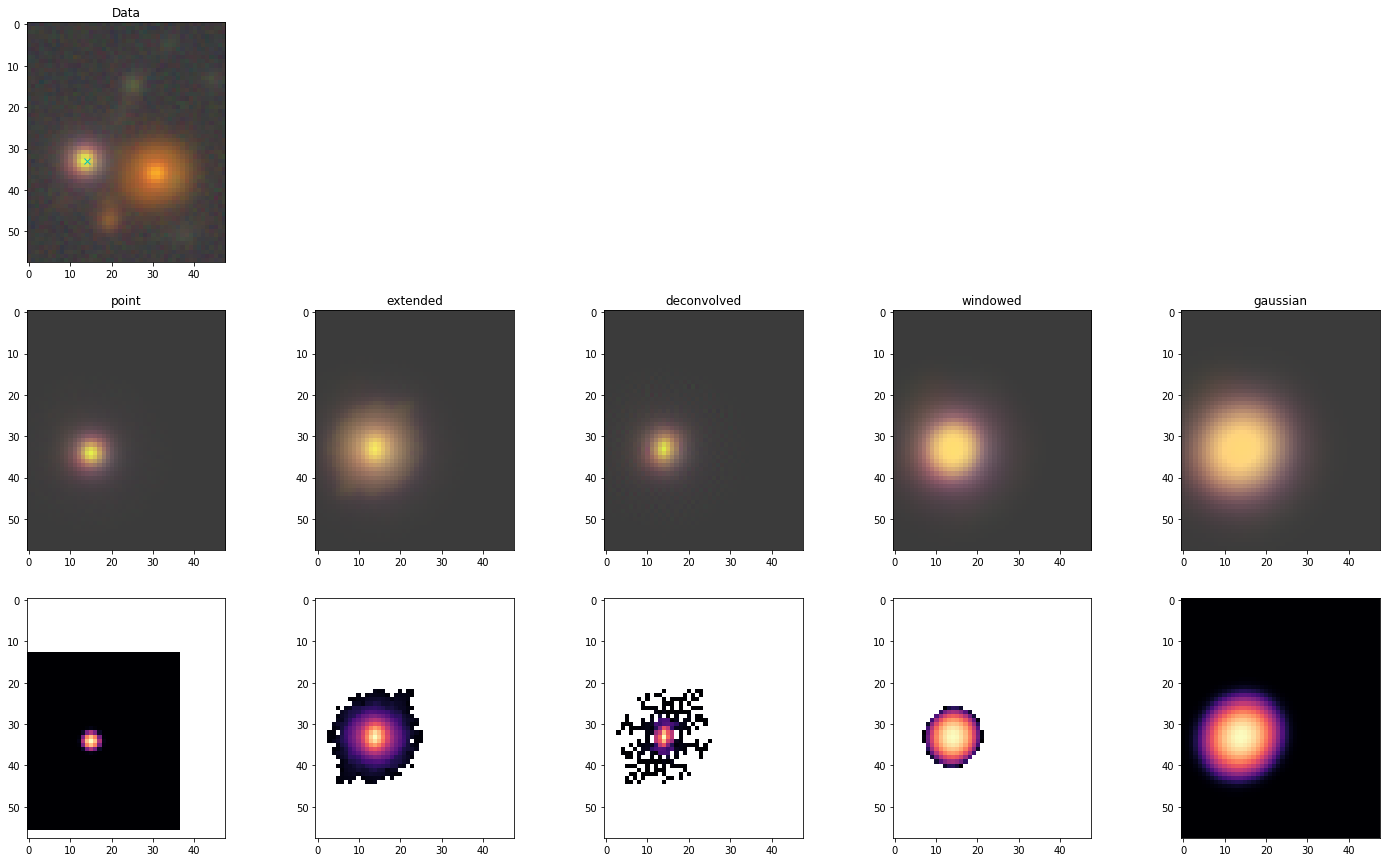

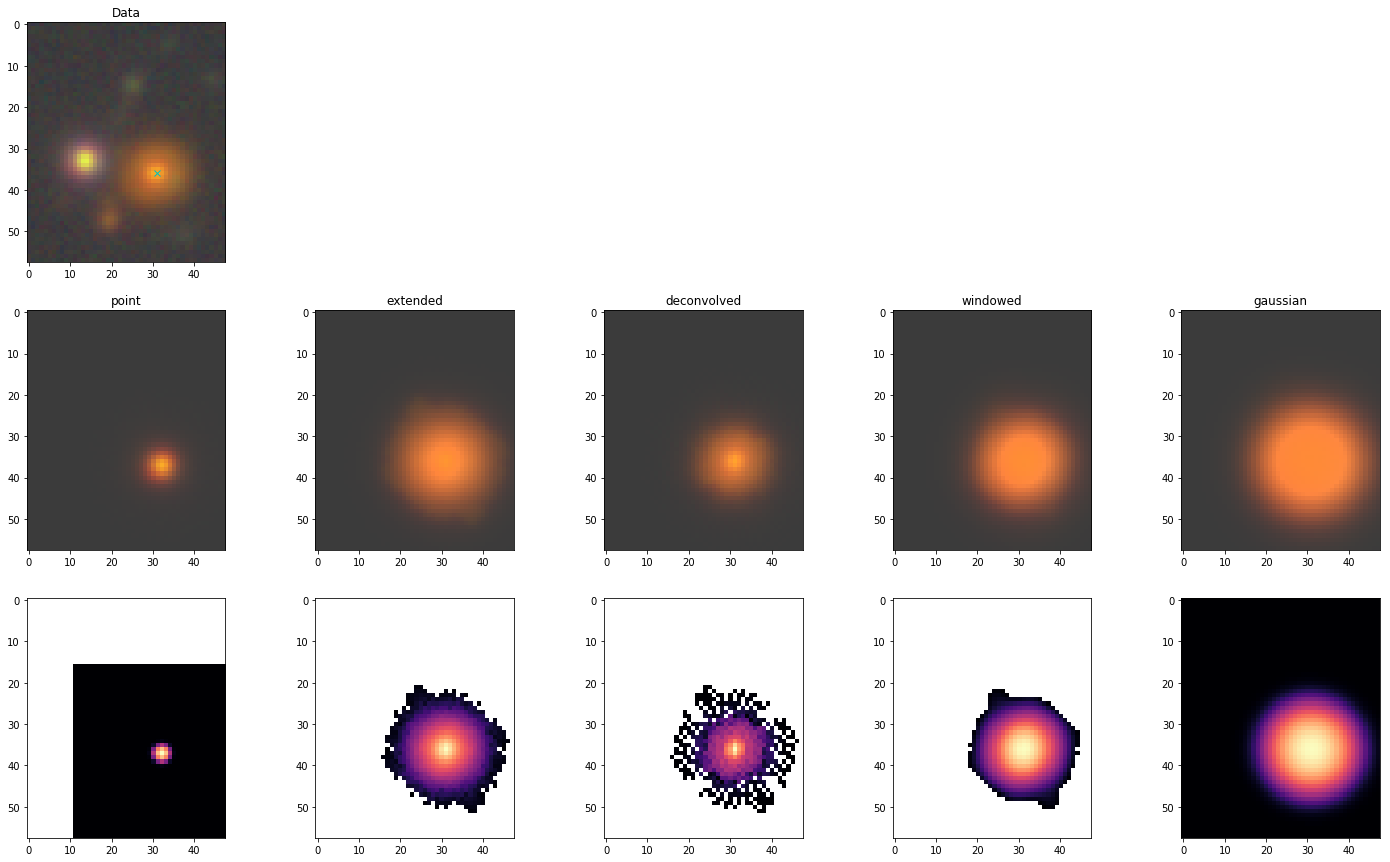

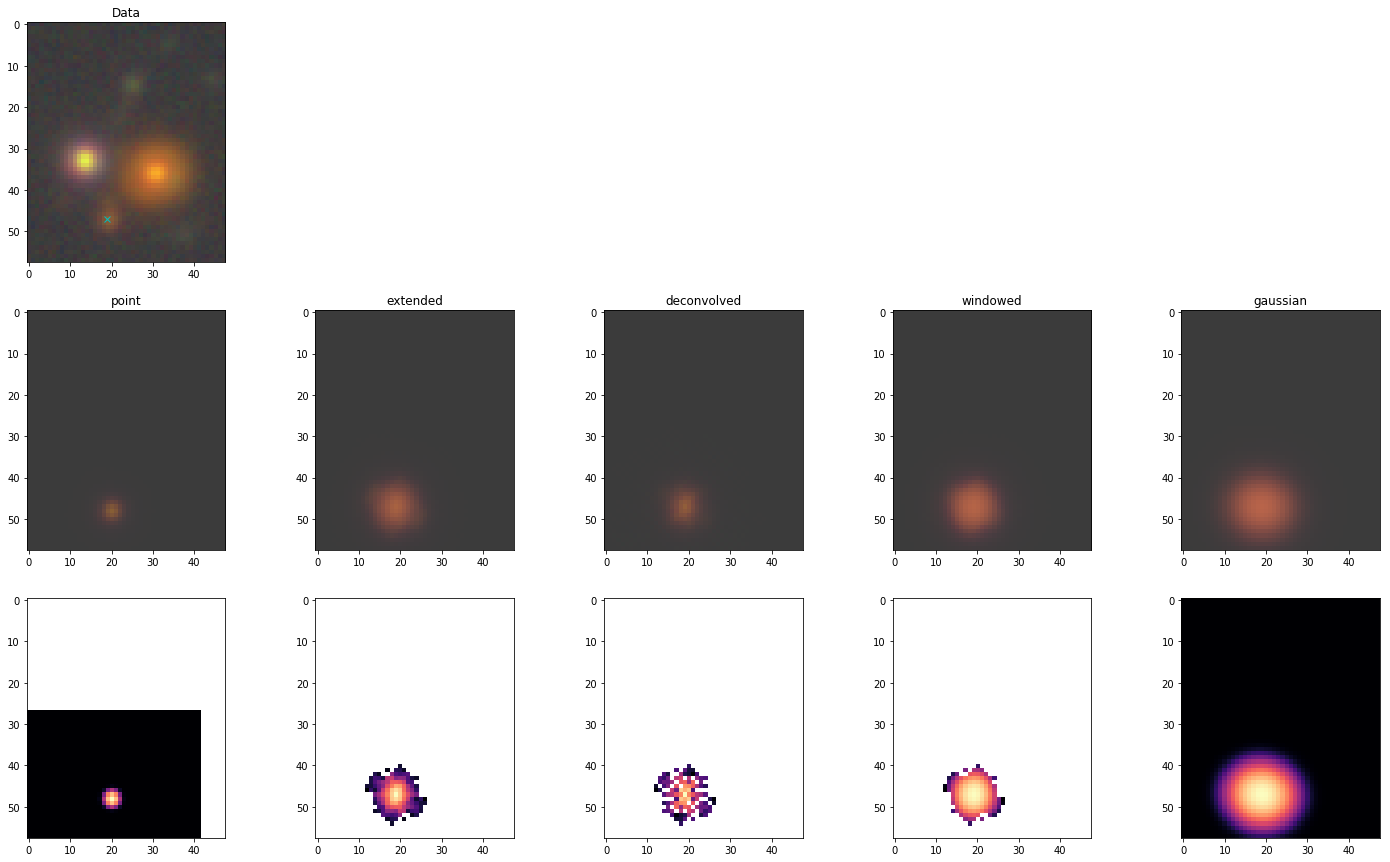

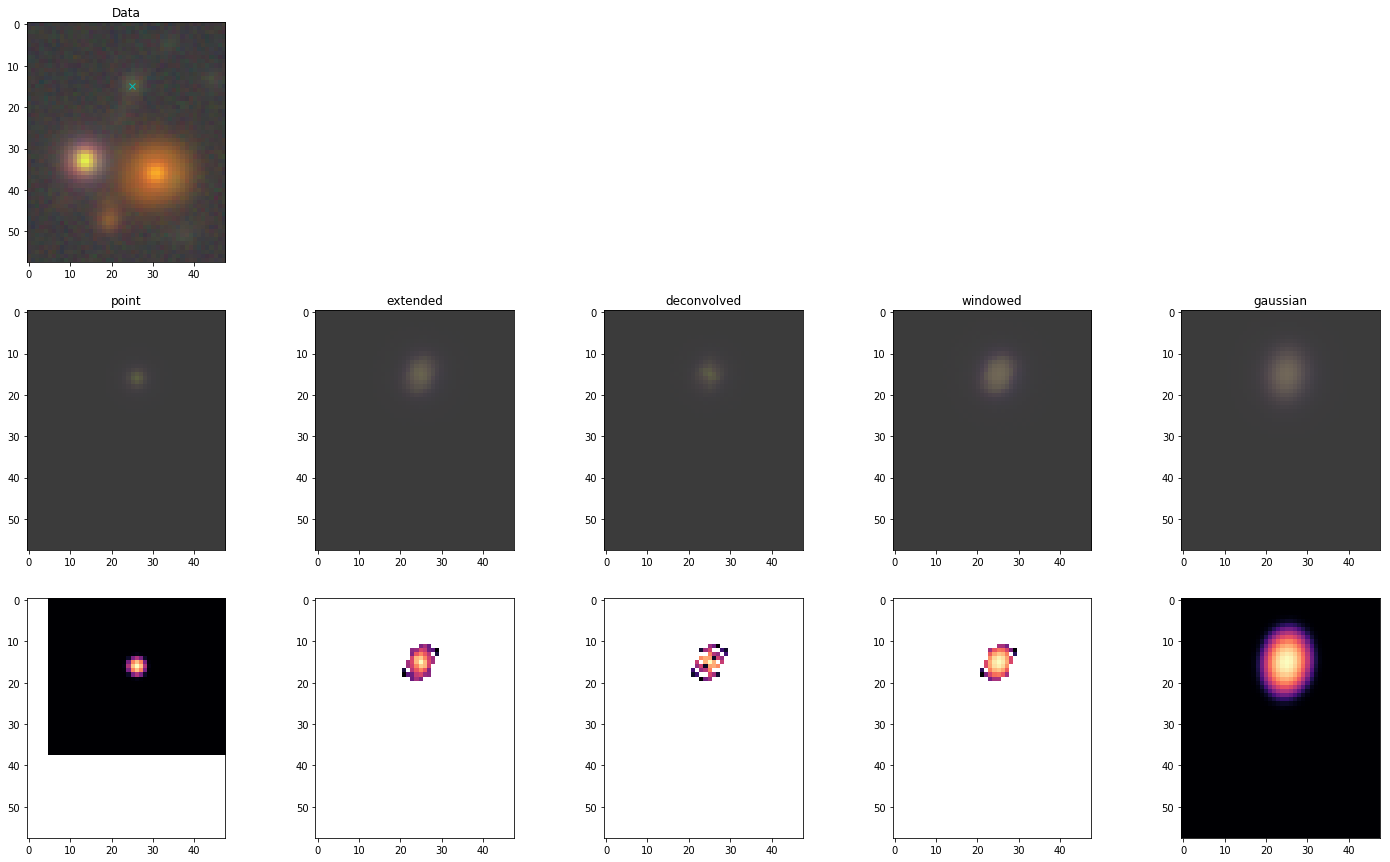

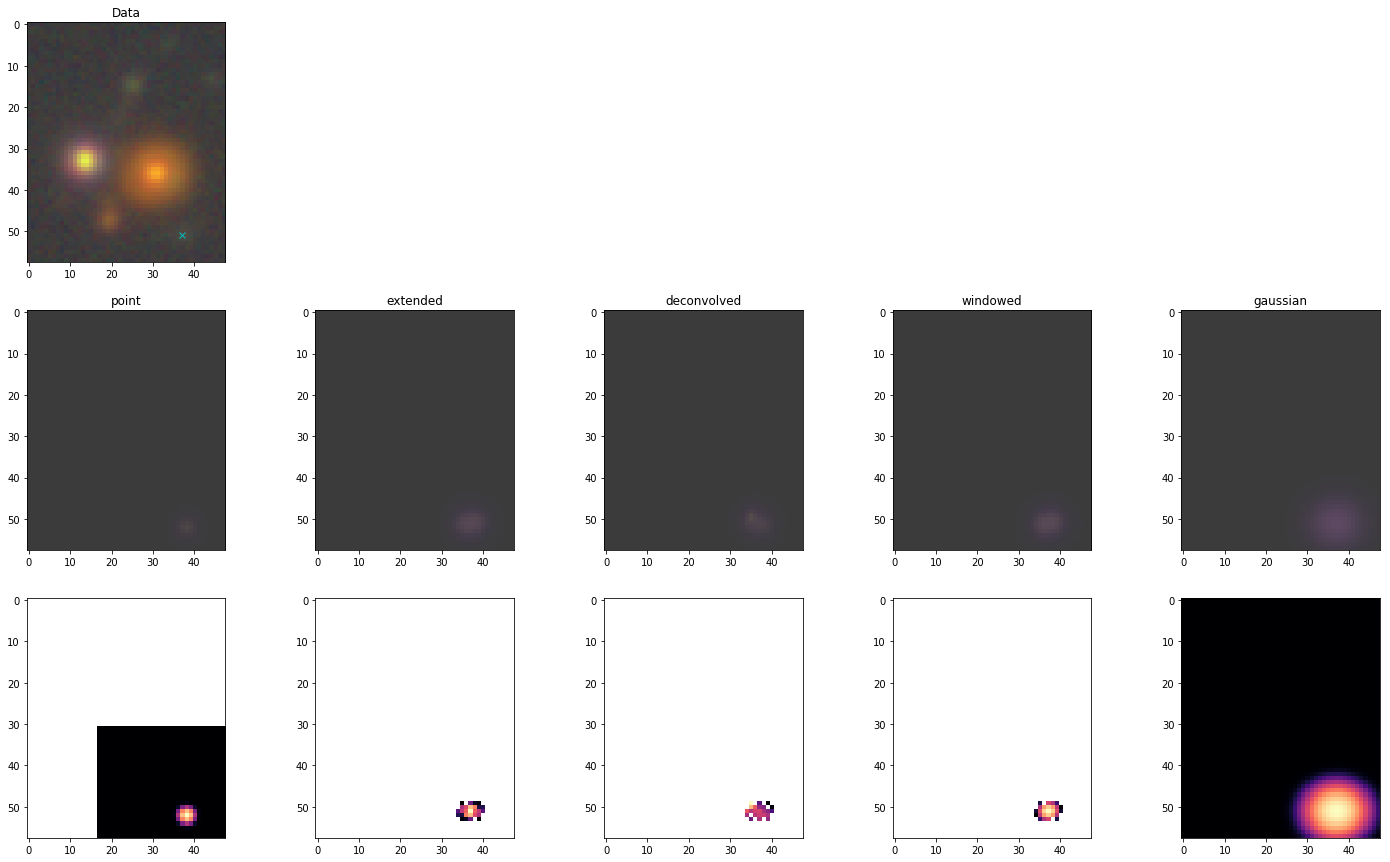

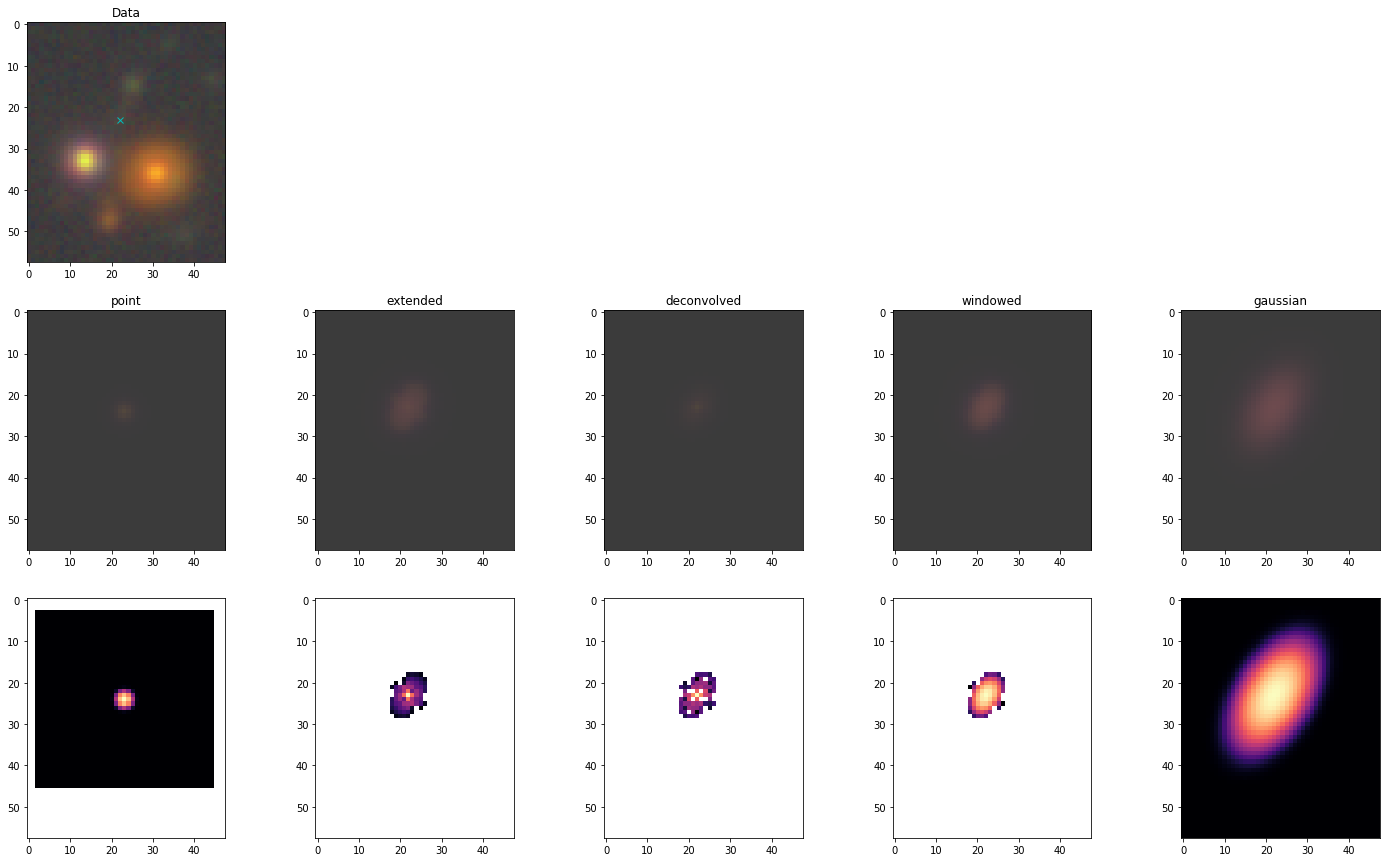

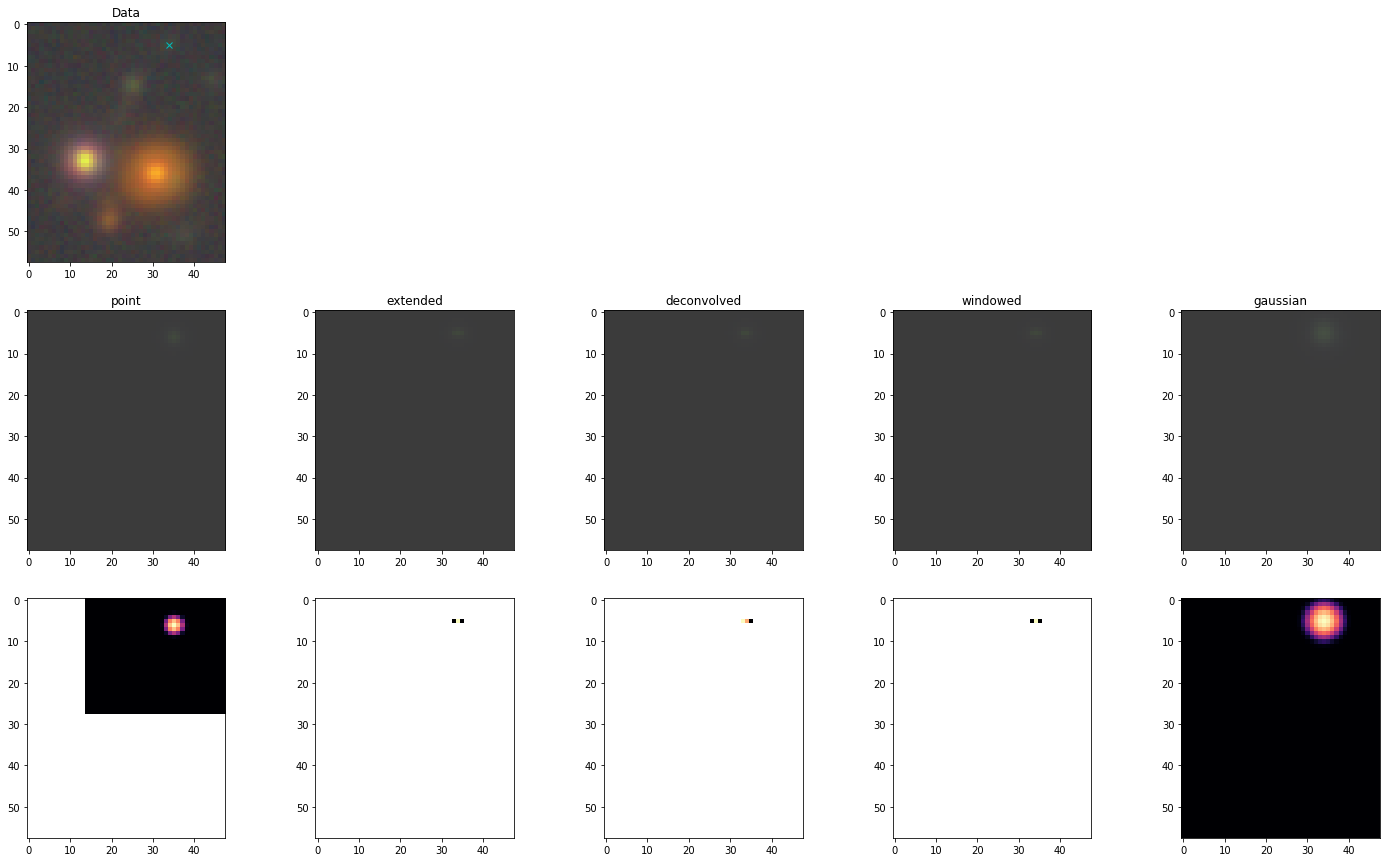

In [5]:
def asinh(model, Q=10):
    return np.arcsinh(Q*model/model.max()*10)/Q

nbr_models = len(sources)

for k in range(len(sources["extended"])):
    fig, ax = plt.subplots(3, nbr_models, figsize=(5*(nbr_models), 15))
    img_rgb = scarlet.display.img_to_rgb(images[:3], norm=norm)
    ax[0][0].imshow(img_rgb)
    ax[0][0].set_title("Data")
    for a in range(1, len(ax[0])):
        ax[0][a].remove()
    for n, (stype, srcs) in enumerate(sources.items()):
        src = srcs[k]
        img_rgb = scarlet.display.img_to_rgb(observation.render(src.get_model())[:3], norm=norm)
        ax[1][n].imshow(img_rgb)
        ax[1][n].set_title(stype)
        ax[2][n].imshow(asinh(np.ma.array(src.morph, mask=src.morph<=0)))
    ax[0][0].plot(src.pixel_center[1], src.pixel_center[0], "cx")
    plt.show()

# Deblend the scene up to relative error = $10^{-2}$

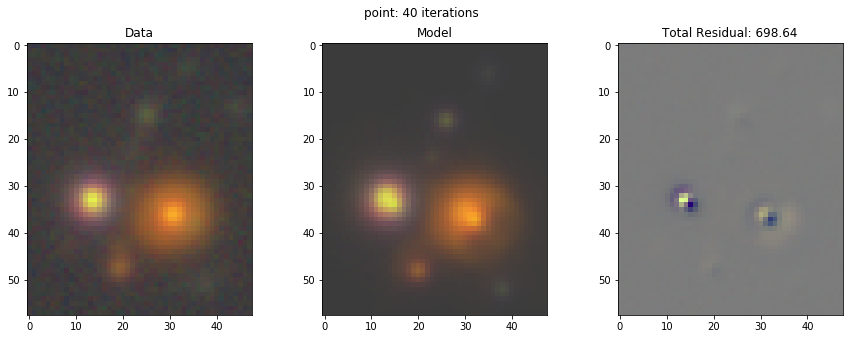

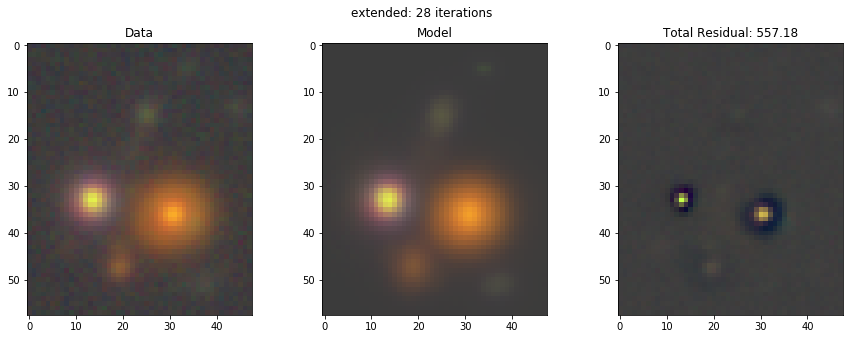

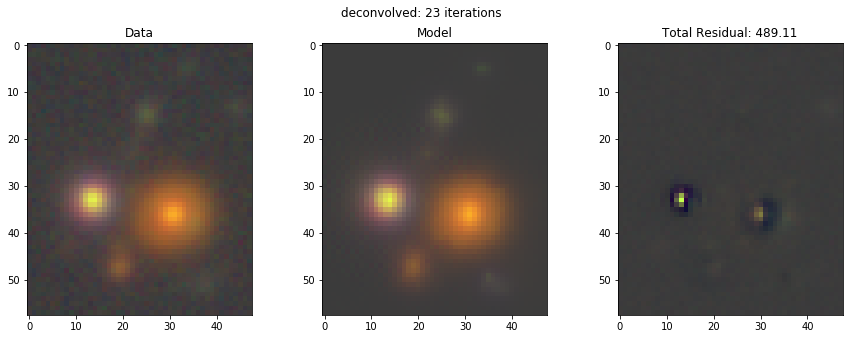

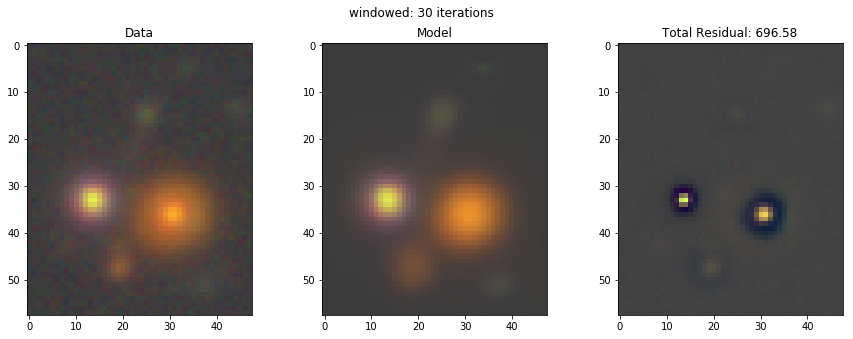

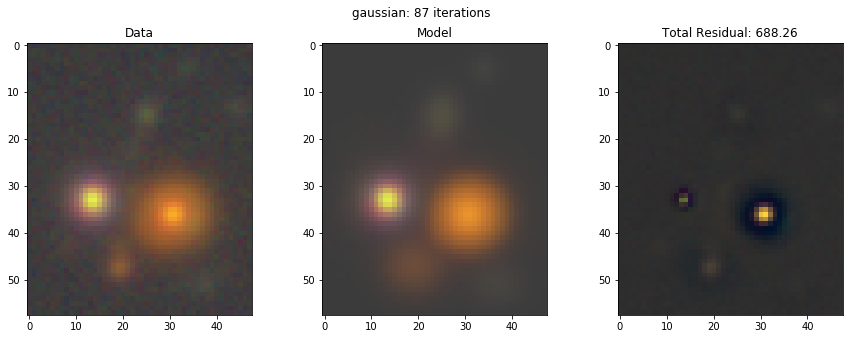

In [6]:
blends = {}
for stype, srcs in sources.items():
    blend = scarlet.Blend(srcs, observation)
    blend.fit(200, e_rel=1e-2)
    blends[stype] = blend
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("{0}: {1} iterations".format(stype, blend.it))
    img_rgb = scarlet.display.img_to_rgb(images[:3], norm=norm)
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    img_rgb = scarlet.display.img_to_rgb(observation.render(blend.get_model())[:3], norm=norm)
    ax[1].imshow(img_rgb)
    ax[1].set_title("Model")
    residual = images - observation.render(blend.get_model())
    img_rgb = scarlet.display.img_to_rgb(residual[:3])
    ax[2].imshow(img_rgb)
    ax[2].set_title("Total Residual: {0:.2f}".format(np.abs(residual).sum()))
    plt.show()

# View sources after convergence

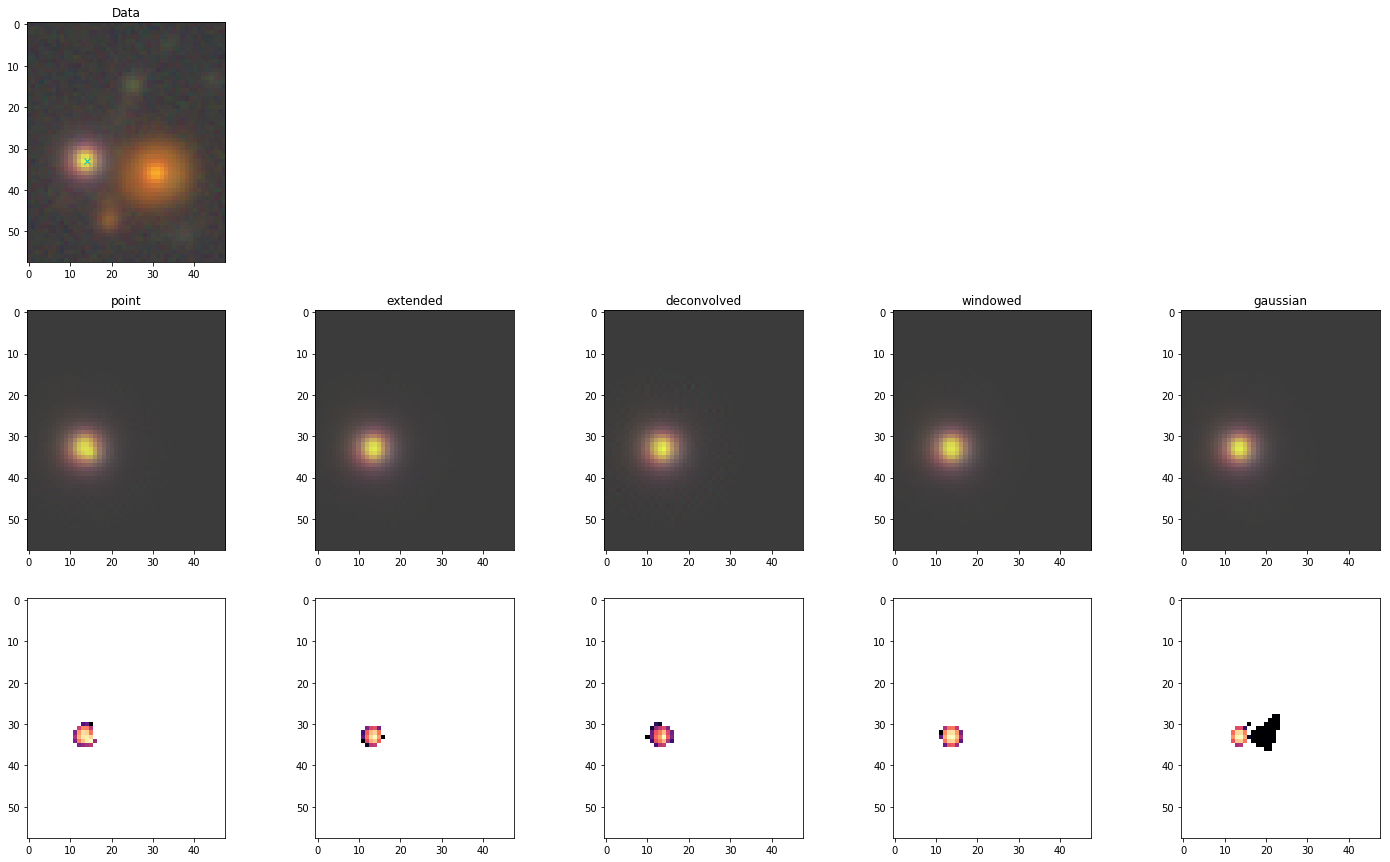

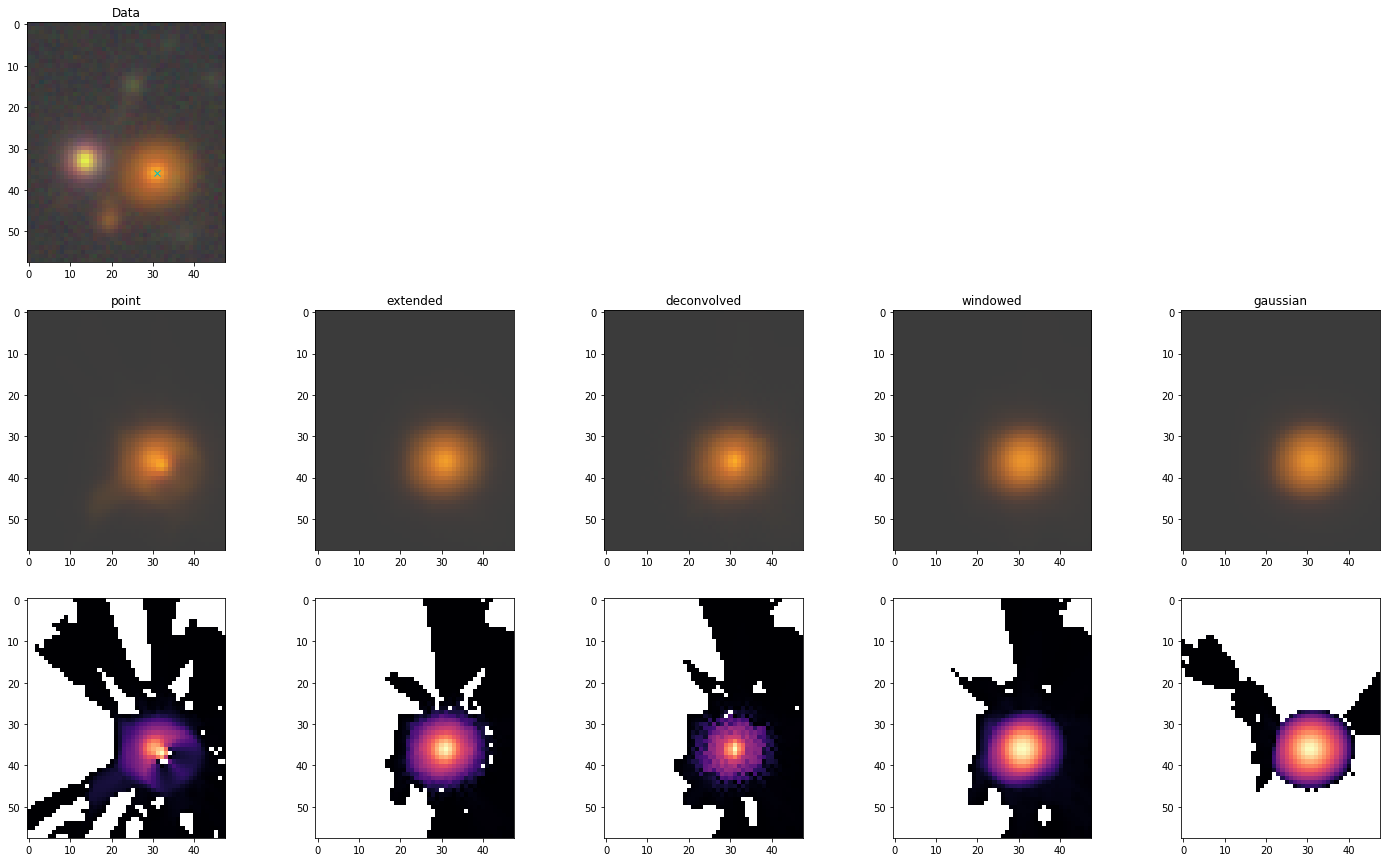

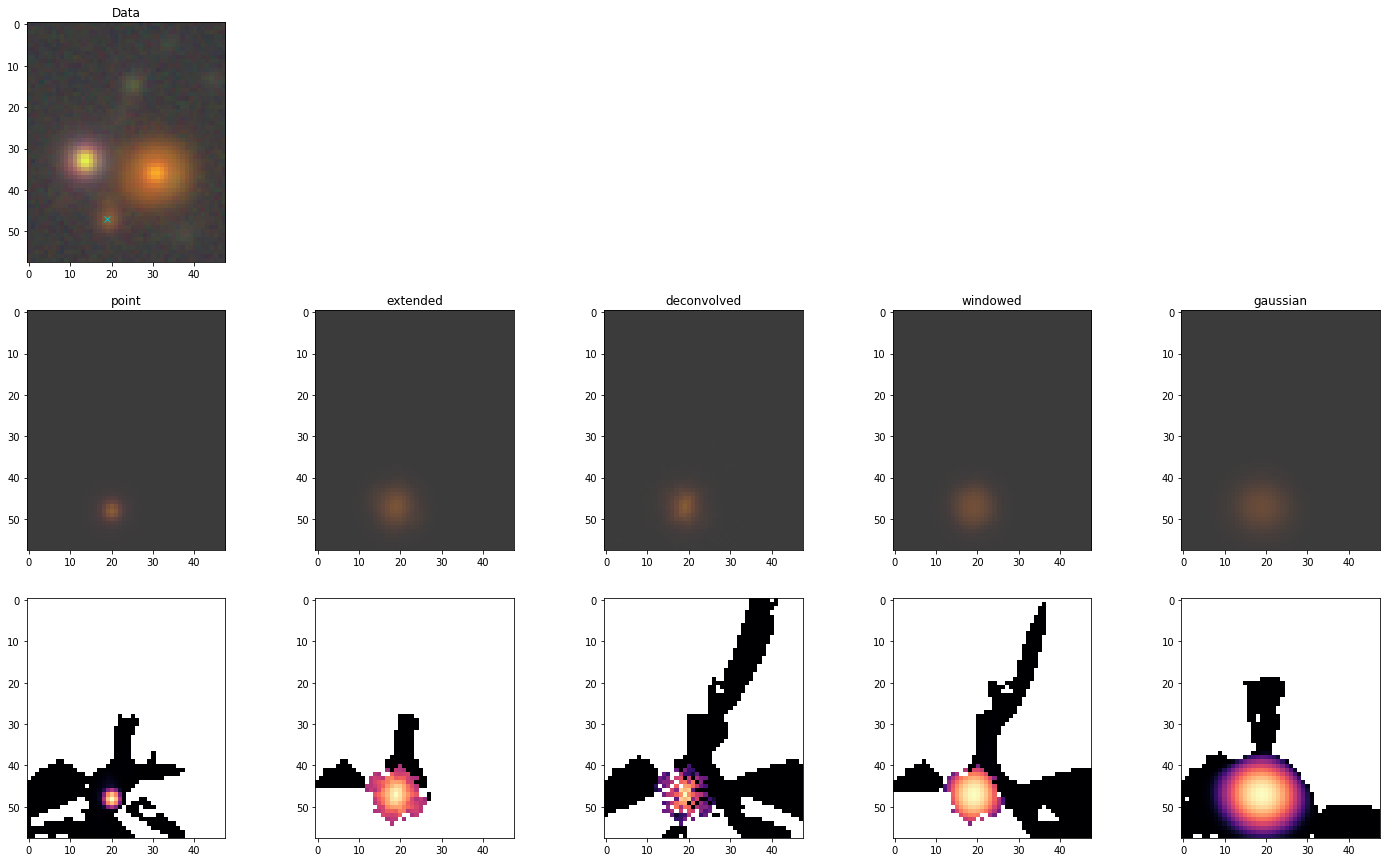

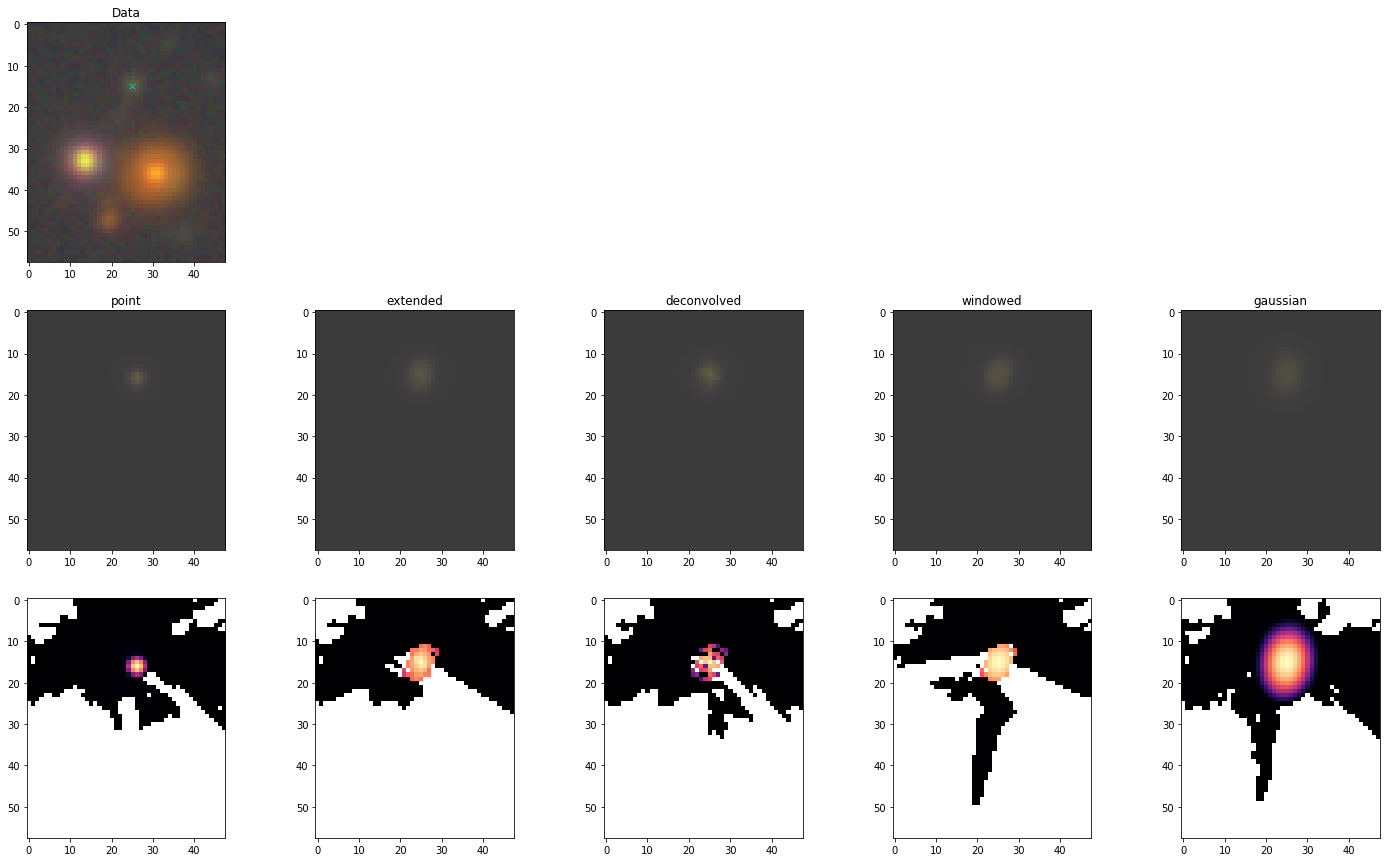

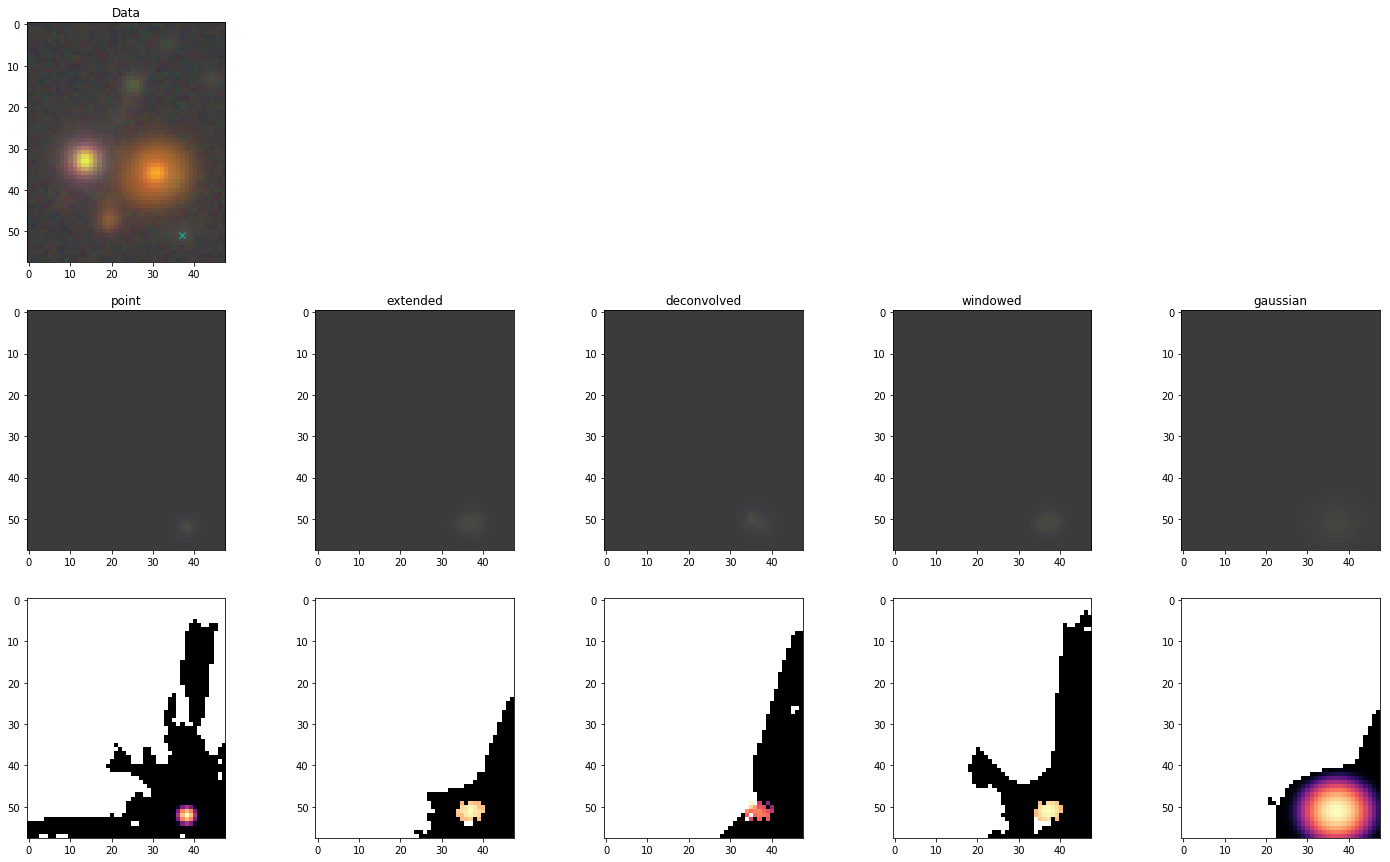

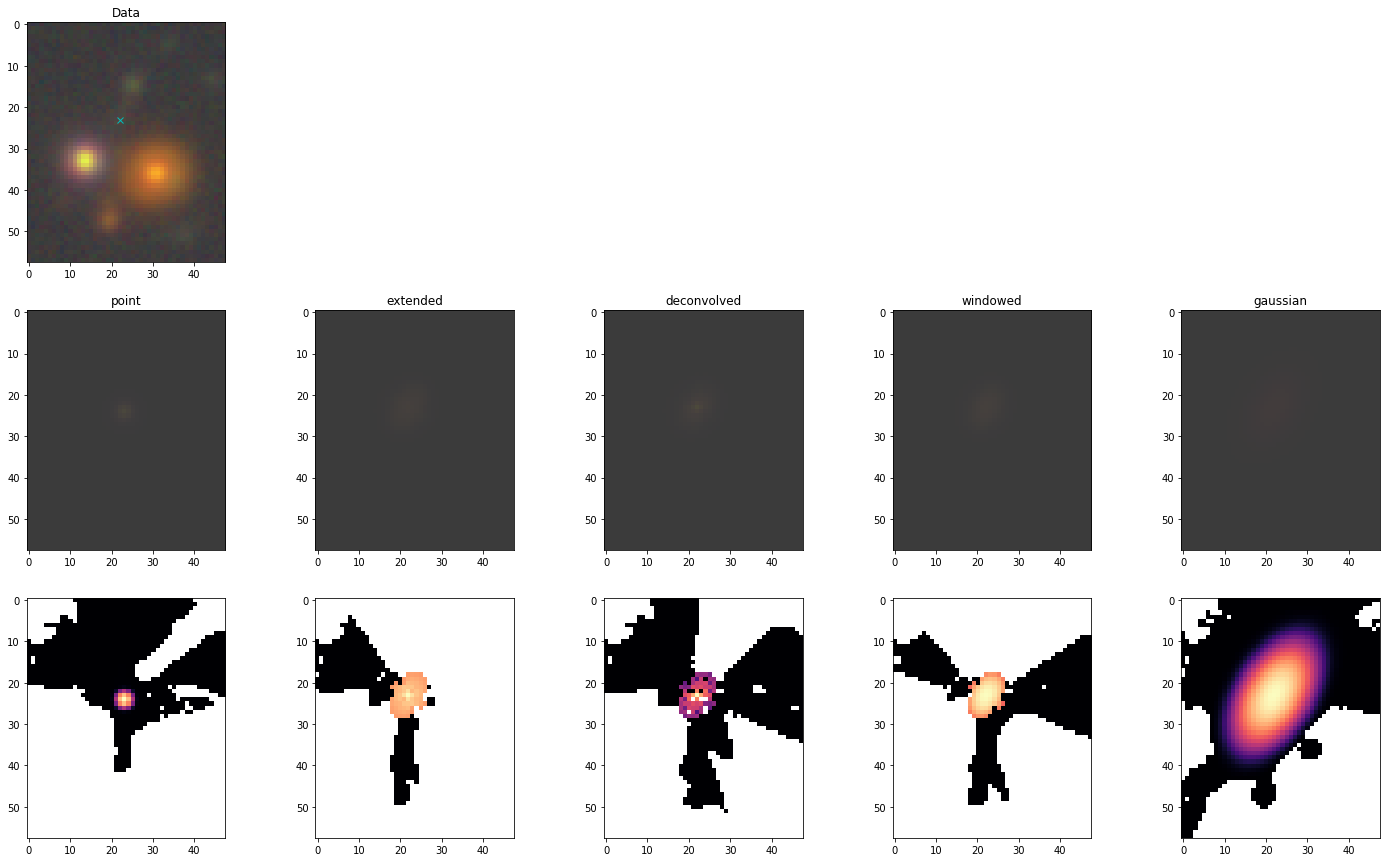

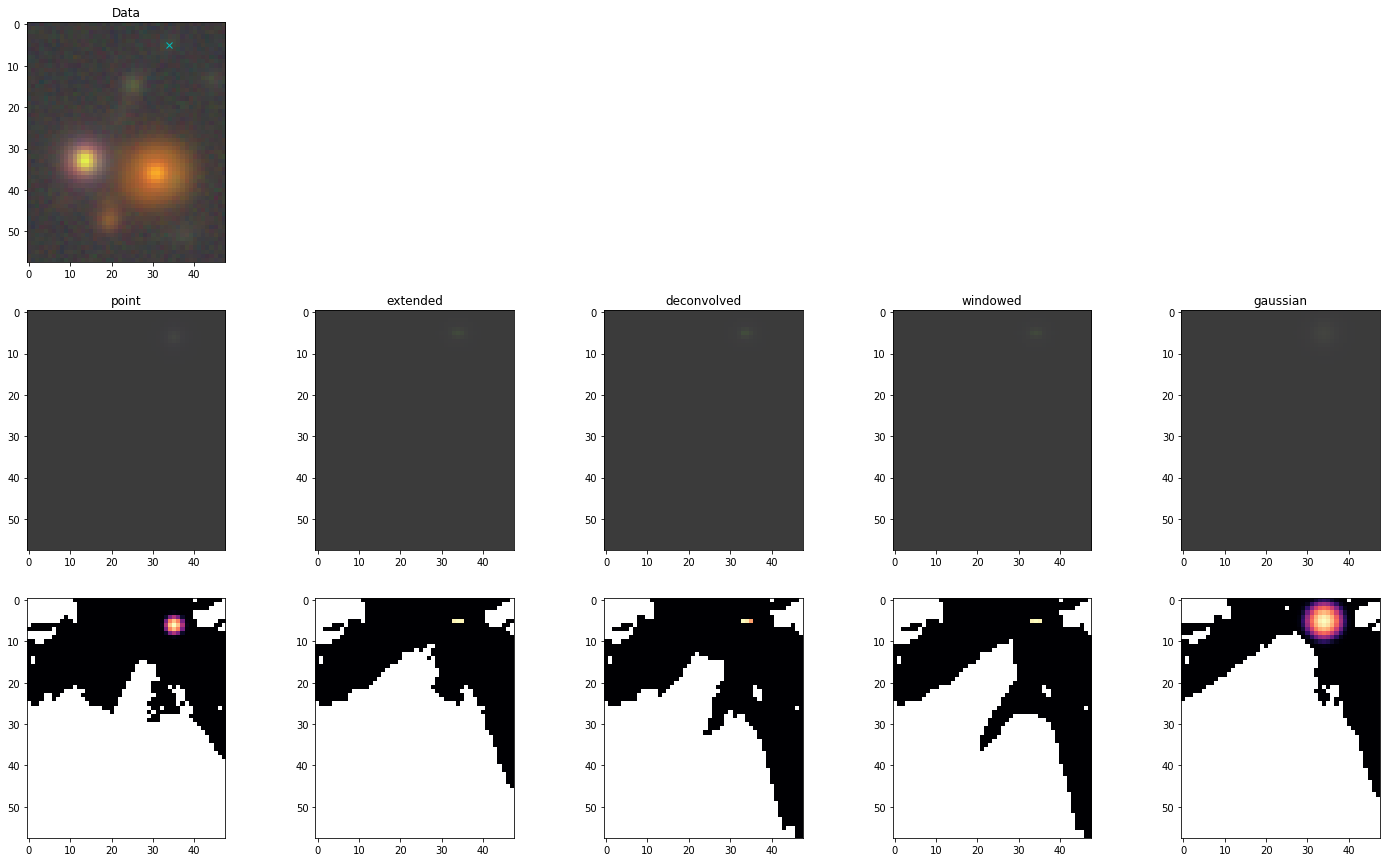

In [7]:
for k in range(len(sources["extended"])):
    fig, ax = plt.subplots(3, nbr_models, figsize=(5*(nbr_models), 15))
    img_rgb = scarlet.display.img_to_rgb(images[:3], norm=norm)
    ax[0][0].imshow(img_rgb)
    ax[0][0].set_title("Data")
    for a in range(1, len(ax[0])):
        ax[0][a].remove()
    for n, (stype, blend) in enumerate(blends.items()):
        src = blend.sources[k]
        img_rgb = scarlet.display.img_to_rgb(observation.render(src.get_model())[:3], norm=norm)
        ax[1][n].imshow(img_rgb)
        ax[1][n].set_title(stype)
        ax[2][n].imshow(asinh(np.ma.array(src.morph, mask=src.morph<=0)))
    ax[0][0].plot(src.pixel_center[1], src.pixel_center[0], "cx")
    plt.show()

# Deblend again until reaching relative error = $10^{-3}$

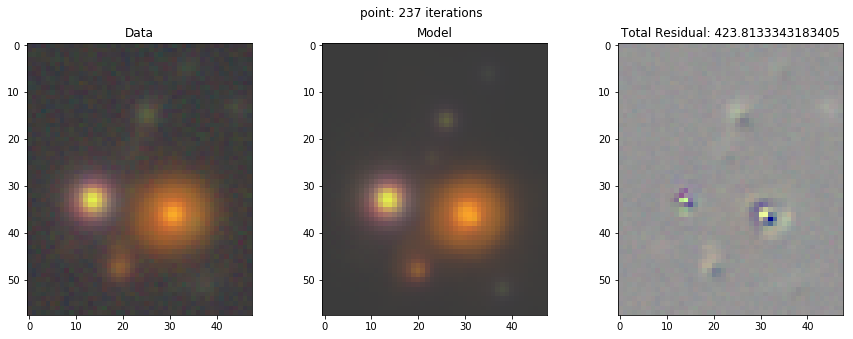

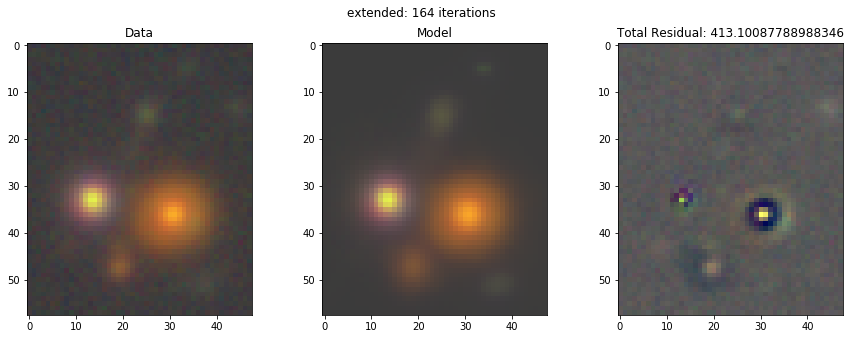

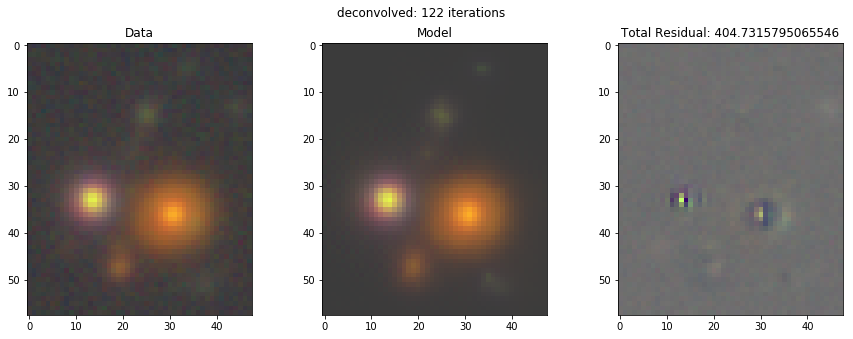

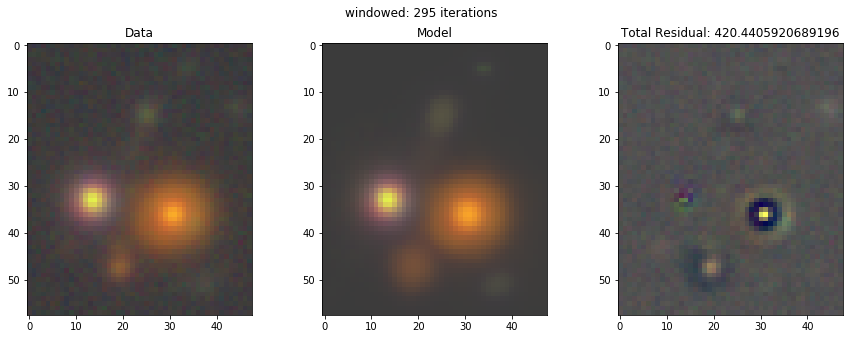

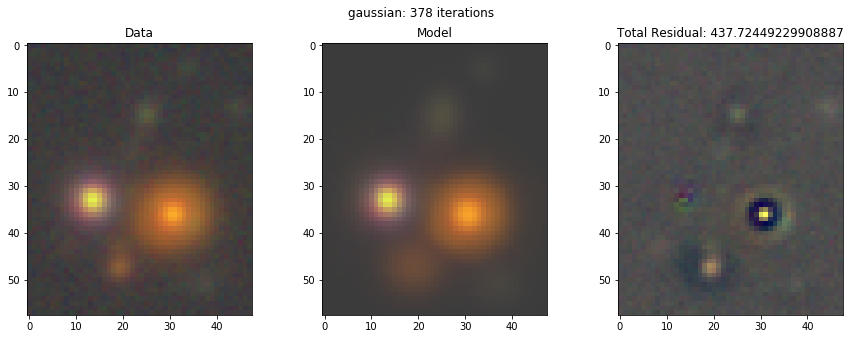

In [8]:
for stype, blend in blends.items():
    blend.fit(500, e_rel=1e-3)
    blends[stype] = blend
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("{0}: {1} iterations".format(stype, blend.it))
    img_rgb = scarlet.display.img_to_rgb(images[:3], norm=norm)
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    img_rgb = scarlet.display.img_to_rgb(observation.render(blend.get_model())[:3], norm=norm)
    ax[1].imshow(img_rgb)
    ax[1].set_title("Model")
    residual = images - observation.render(blend.get_model())
    img_rgb = scarlet.display.img_to_rgb(residual[:3])
    ax[2].imshow(img_rgb)
    ax[2].set_title("Total Residual: {0}".format(np.abs(residual).sum()))
    plt.show()

# Display final source models

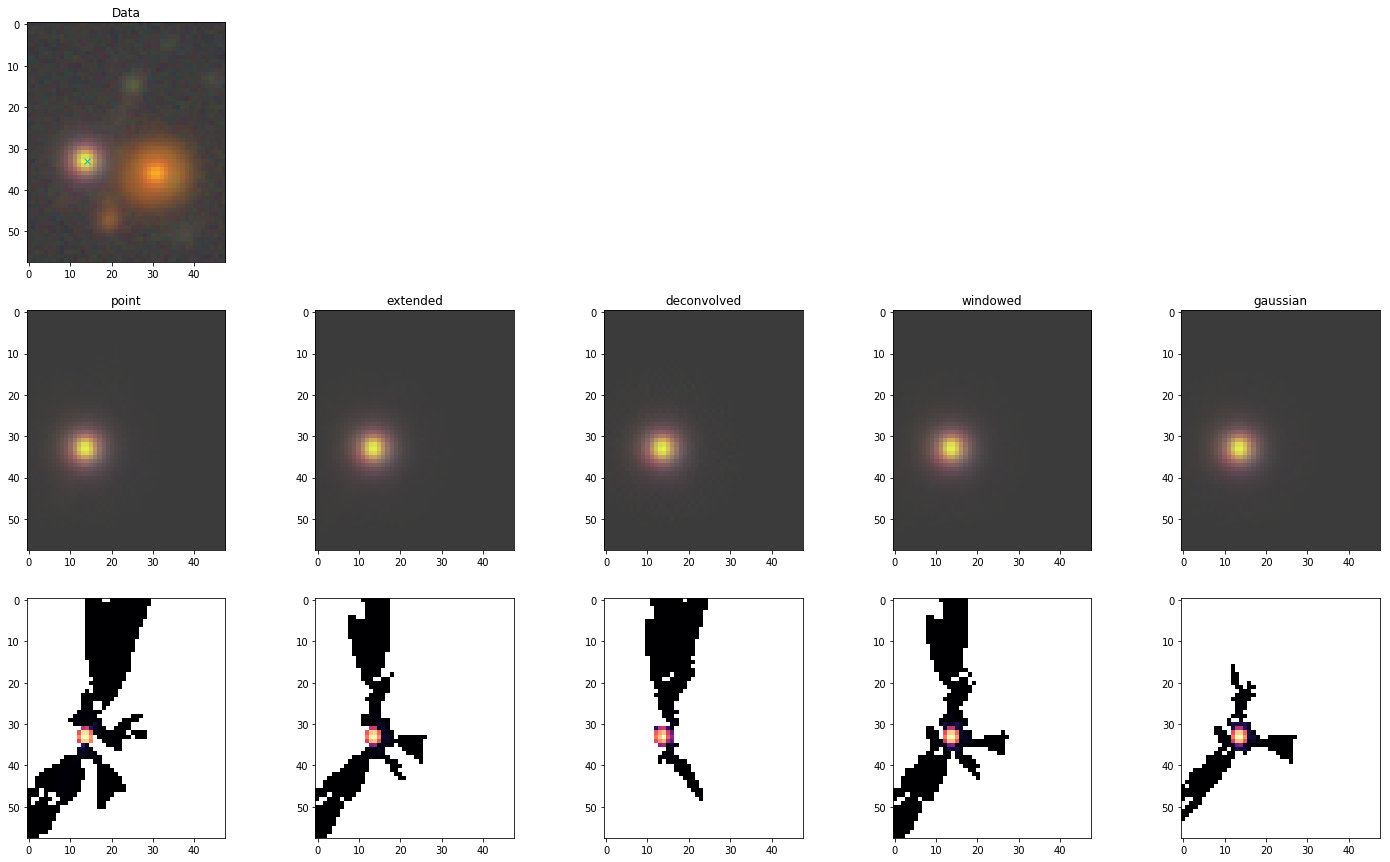

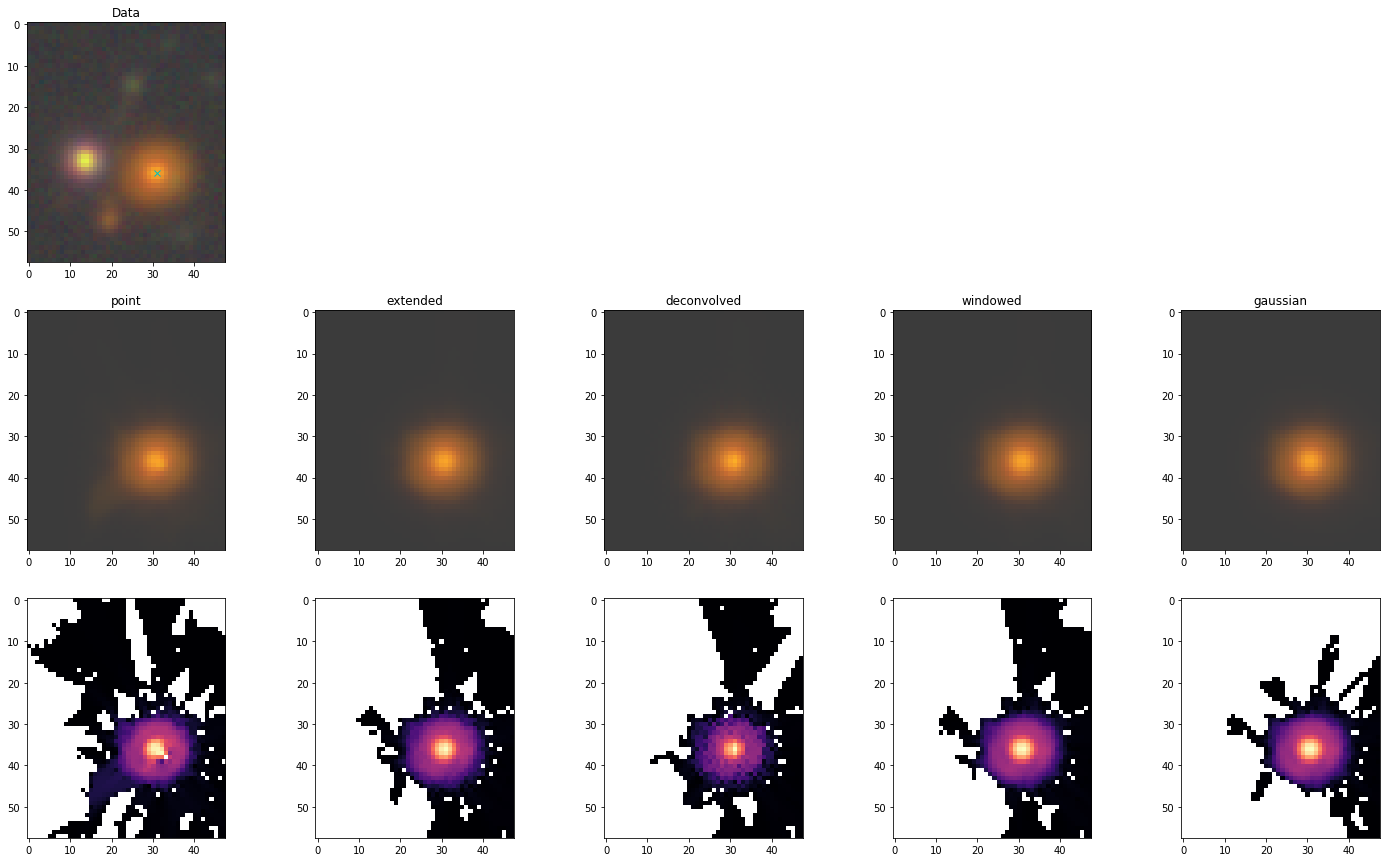

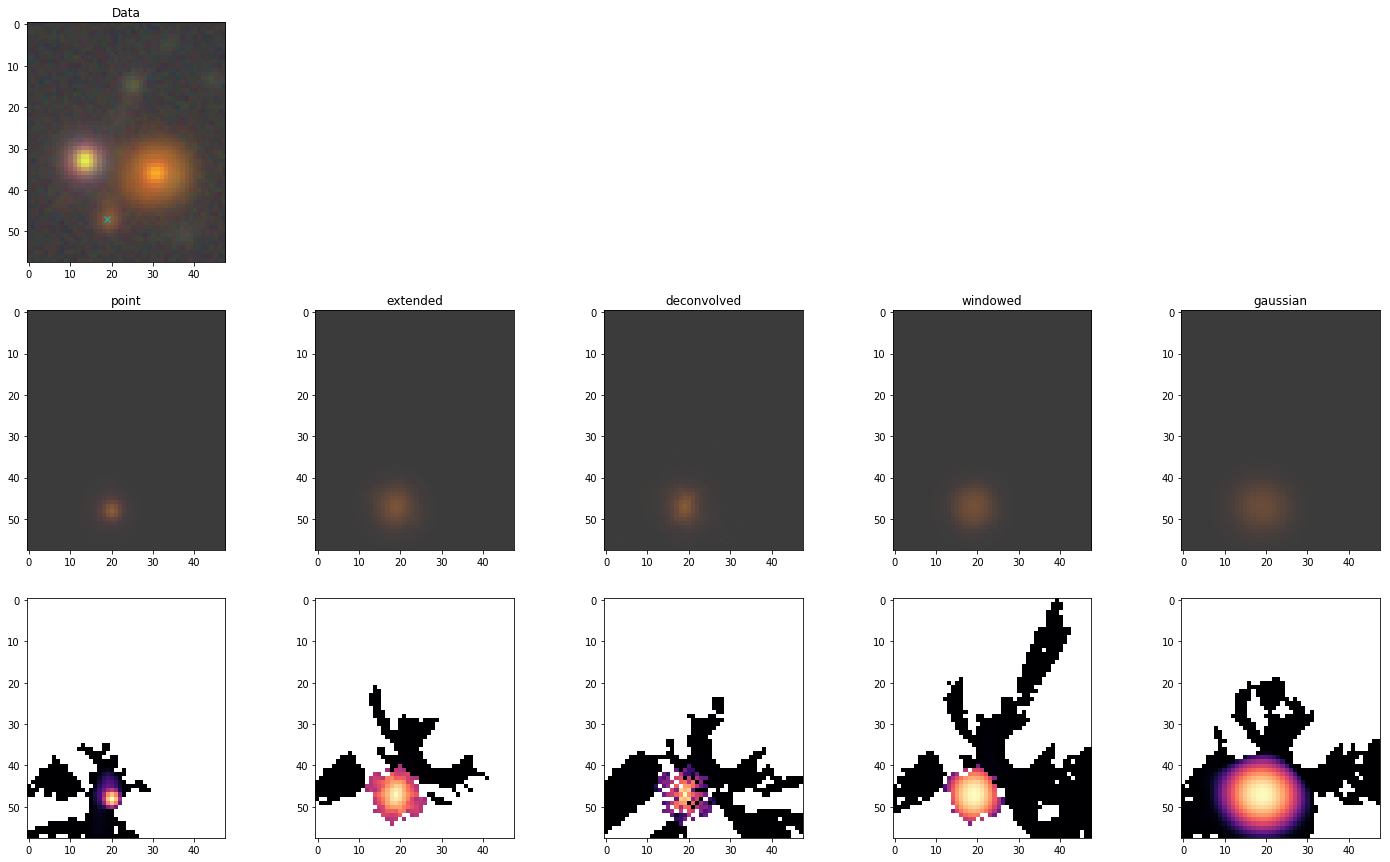

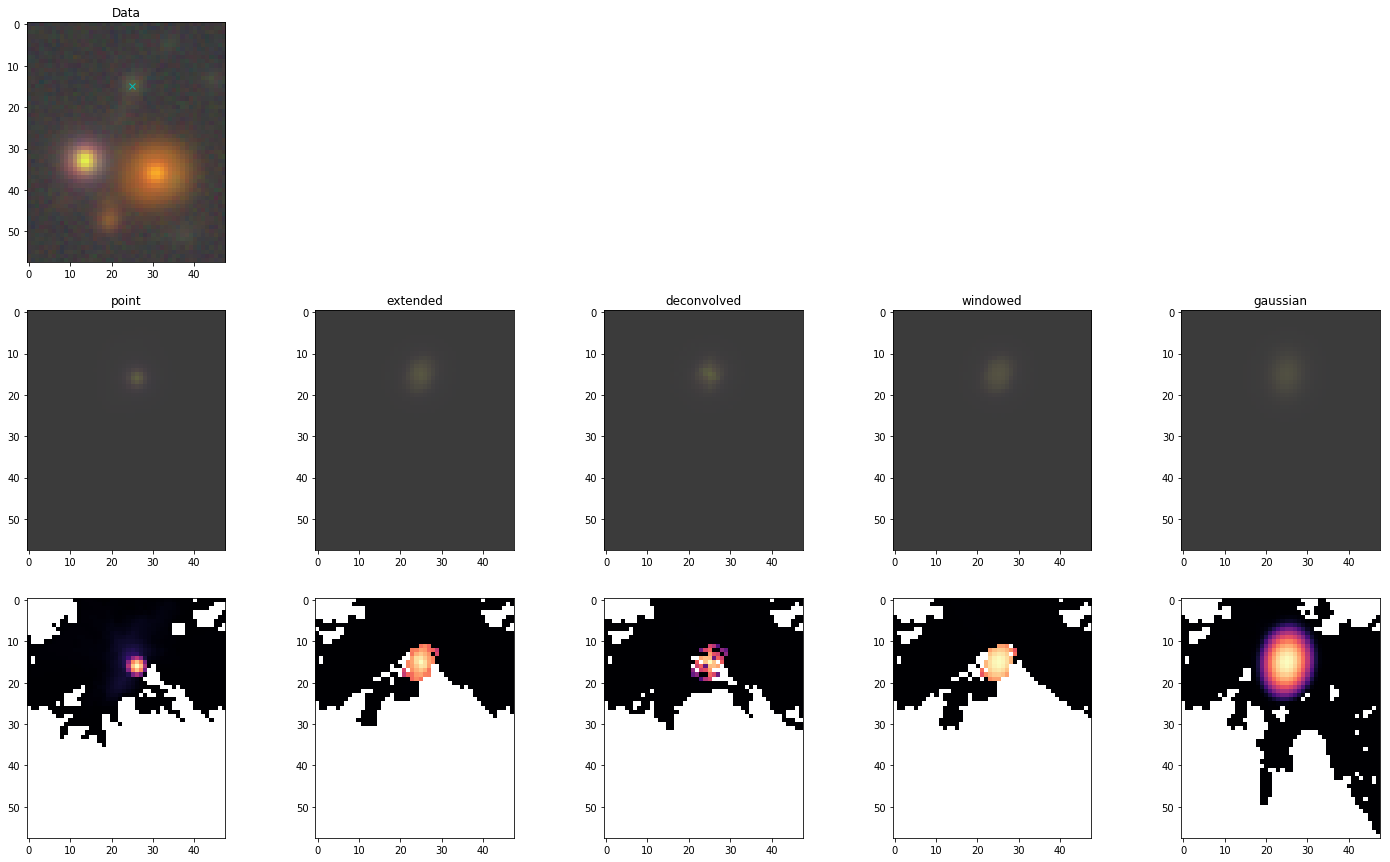

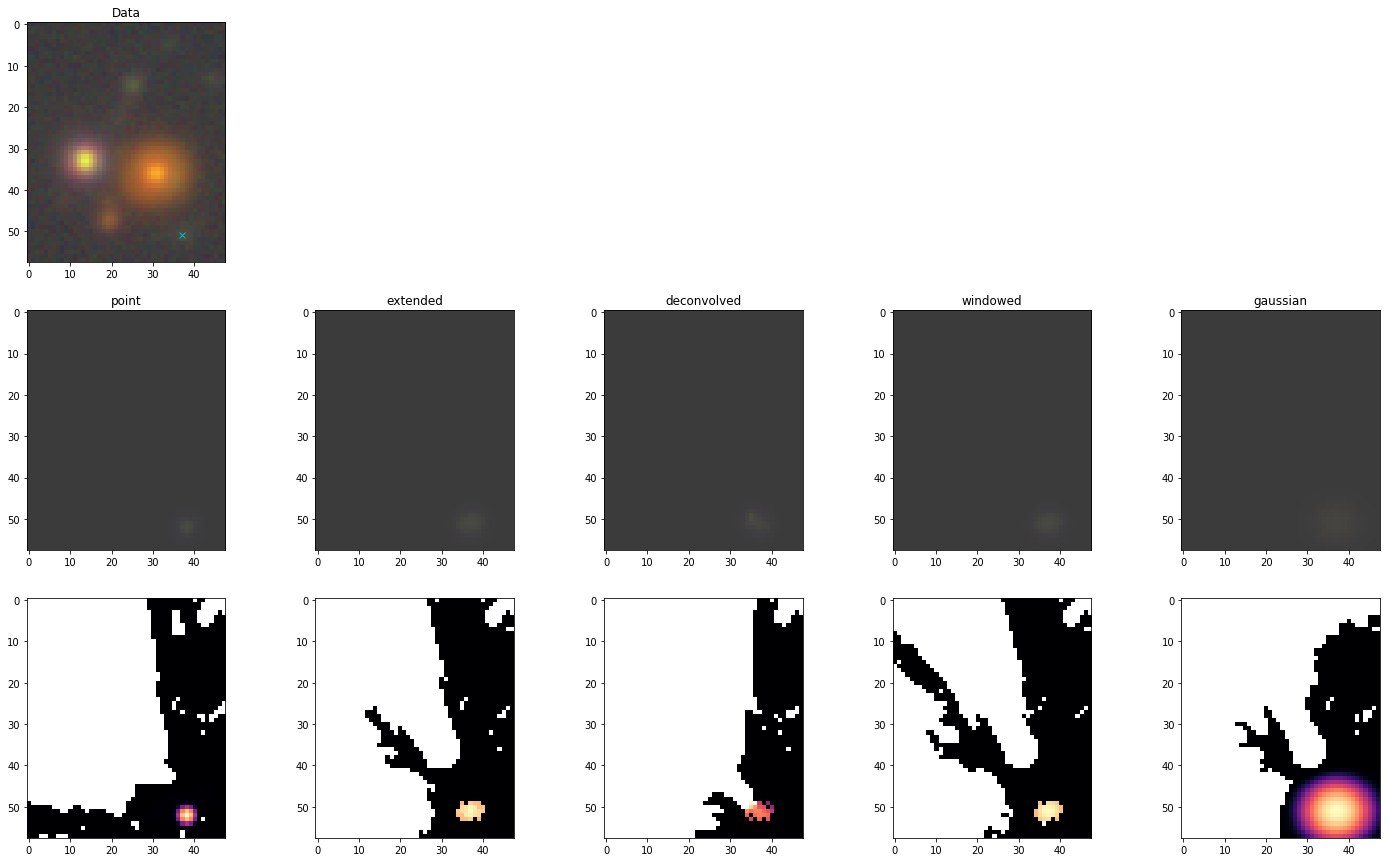

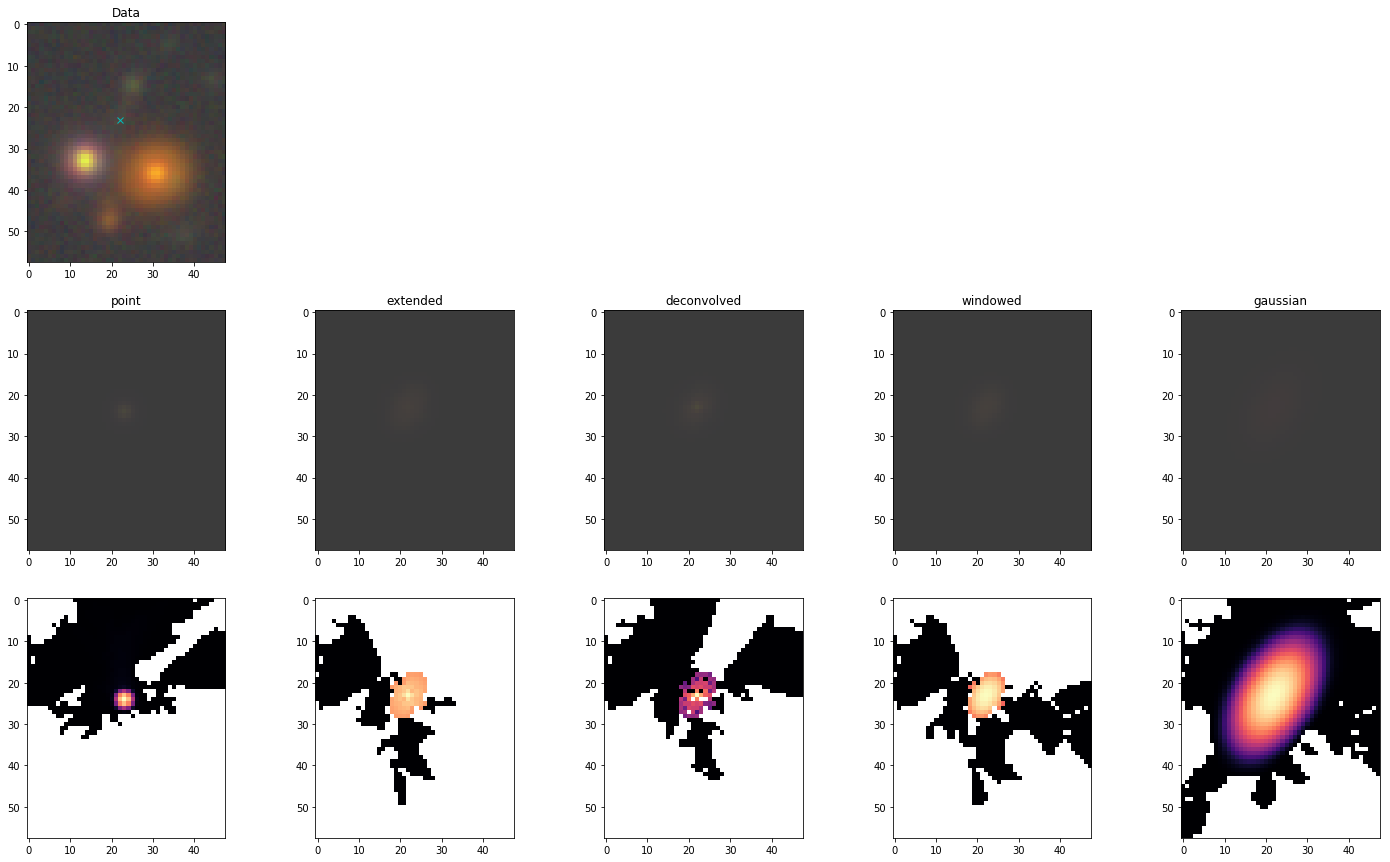

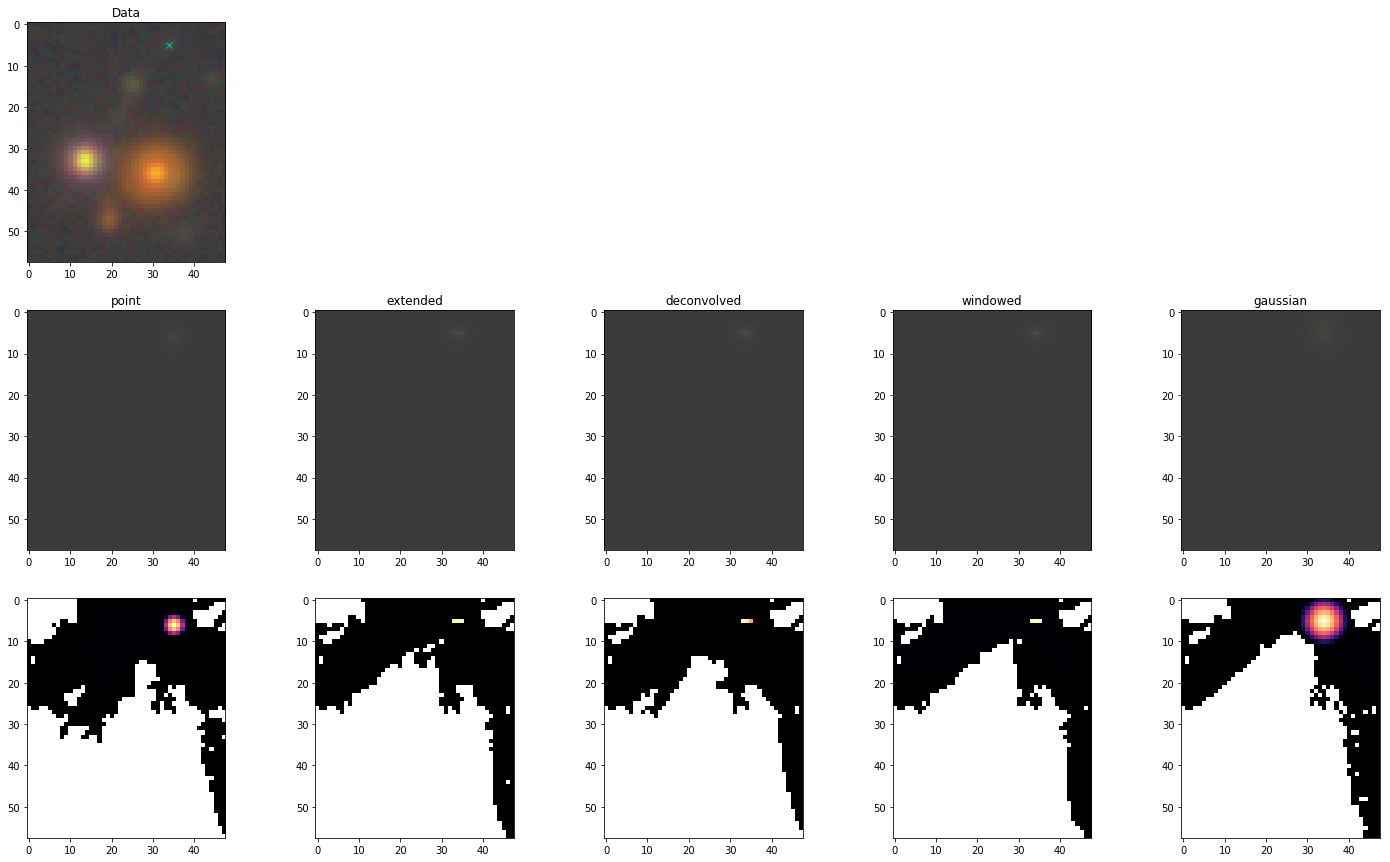

In [9]:
for k in range(len(sources["extended"])):
    fig, ax = plt.subplots(3, nbr_models, figsize=(5*(nbr_models), 15))
    img_rgb = scarlet.display.img_to_rgb(images[:3], norm=norm)
    ax[0][0].imshow(img_rgb)
    ax[0][0].set_title("Data")
    for a in range(1, len(ax[0])):
        ax[0][a].remove()
    for n, (stype, blend) in enumerate(blends.items()):
        src = blend.sources[k]
        img_rgb = scarlet.display.img_to_rgb(observation.render(src.get_model())[:3], norm=norm)
        ax[1][n].imshow(img_rgb)
        ax[1][n].set_title(stype)
        ax[2][n].imshow(asinh(np.ma.array(src.morph, mask=src.morph<=0)))
    ax[0][0].plot(src.pixel_center[1], src.pixel_center[0], "cx")
    plt.show()

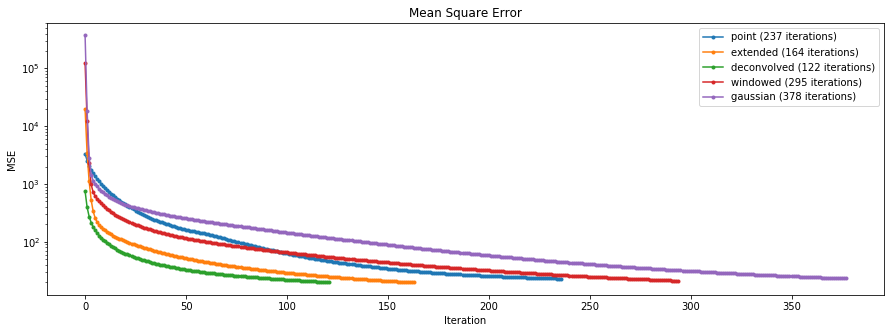

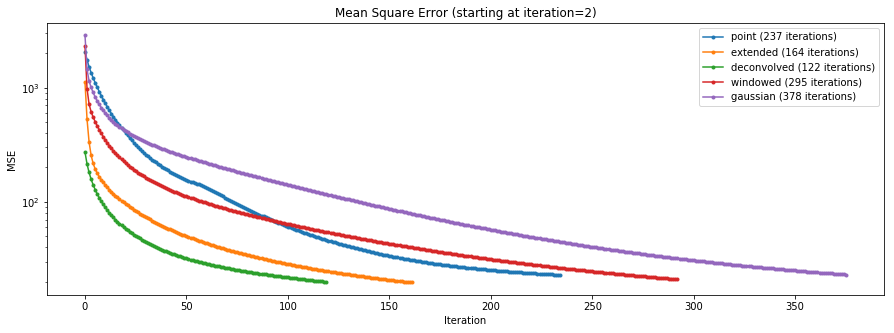

In [16]:
plt.figure(figsize=(15, 5))
for stype, blend in blends.items():
    plt.semilogy(blend.mse, ".-", label="{0} ({1} iterations)".format(stype, blend.it))
plt.legend()
plt.title("Mean Square Error")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

plt.figure(figsize=(15, 5))
for stype, blend in blends.items():
    plt.semilogy(blend.mse[2:], ".-", label="{0} ({1} iterations)".format(stype, blend.it))
plt.legend()
plt.title("Mean Square Error (starting at iteration=2)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()